In [1]:
import pandas
import pm4py
import csv
import numpy as np
from minisom import MiniSom
import matplotlib.pyplot as plt
from tqdm import tqdm 
from old_code.train import TrainSOM
from preprocessing import PreProcessing
from sklearn.decomposition import PCA
from pm4py.algo.querying.llm.abstractions import log_to_fea_descr
import intrasom
from intrasom.visualization import PlotFactory
from intrasom.clustering import ClusterFactory
import json


The preprocessing step cannot be executed due to data privacy, but from step 5 it is possible to use feature matrix to train SOM

### 1. Read M2C event-log files

In [2]:
event_log = pandas.read_csv("data/event_log_m2c.csv",  delimiter=",", encoding='utf-8')
case_attributes = pandas.read_csv("data/case_attributes_m2c.csv",  delimiter=",", encoding='cp1252', quoting=csv.QUOTE_NONE, quotechar='"')

/var/folders/hh/pvwk6s4917qdt0_j791cx6wc0000gn/T/ipykernel_30231/3309358021.py:2: DtypeWarning: Columns (9,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  case_attributes = pandas.read_csv("data/case_attributes_m2c.csv",  delimiter=",", encoding='cp1252', quoting=csv.QUOTE_NONE, quotechar='"')


### 2. Translate activities from german to english

In [3]:
with open('data/translation_dict.json') as json_data:
    data = json.load(json_data)

In [4]:
event_log.replace({'activity': data}, inplace=True)

### 3. Data pre-processing

In [5]:
event_log = pm4py.format_dataframe(event_log, case_id='case_id', activity_key='activity', timestamp_key='timestamp')

In [9]:
file_name = 'data/extracted_features_m.csv'
features = PreProcessing.extract_features(event_log, case_attributes, file_name, activity_flag=2)

### 4. Create and save feature matrix 

In [10]:
feature_matrix = PreProcessing.create_feature_matrix(features)

In [11]:
with open('feature_matrix_m.npy', 'wb') as f:
    np.save(f, feature_matrix)

### 5. Load feature matrix - from here the data is available in GitHub repository 

In [12]:
with open('M_setting/feature_matrix_m.npy', 'rb') as f:
    feature_matrix = np.load(f)

In [13]:
feature_matrix

array([[0.        , 0.02083333, 0.04166667, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.1875    , 0.25      , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02083333, 0.04166667, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.68732635, 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [1.        , 0.08333333, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.08333333, 0.        , ..., 0.        , 0.        ,
        0.        ]])

### 7. Initialize SOM

Configure SOM

In [16]:
som_width, som_height, num_neurons, num_iterations = TrainSOM.config_som(features)
f = features.drop(columns=['case_id'])
print(som_width, som_height, num_neurons, num_iterations)

62 64 3935 1967500


In [17]:
mapsize = (som_width, som_height)
som = intrasom.SOMFactory.build(feature_matrix,
                                        mask=None,
                                        mapsize=mapsize,
                                        mapshape='toroid',
                                        lattice='hexa',
                                        normalization=None,
                                        initialization='random',
                                        neighborhood='gaussian',
                                        training='batch',
                                        name='Example',
                                        component_names=f.columns.to_list(),
                                        unit_names = None,
                                        sample_names=None,
                                        missing=False,
                                        save_nan_hist = False,
                                        pred_size=0)

Loading dataframe...
Normalizing data...
Creating neighborhood...
Initializing map...


Creating Neuron Distance Rows:   0%|          | 0/64 [00:00<?, ?rows/s]

In [18]:
som.train(n_job=4, train_len_factor=2, previous_epoch = True)

Starting Training...
Rough Training:


  0%|          | 0/2 [00:00<?, ?it/s]

Fine Tuning:


  0%|          | 0/2 [00:00<?, ?it/s]

Saving...
Training Report Created
Training completed successfully.


In [19]:
bmus = pandas.read_parquet("M_setting/Results/Example_neurons.parquet")
params = json.load(open("M_setting/Results/params_Example.json", encoding='utf-8'))
som_vis = intrasom.SOMFactory.load_som(data = feature_matrix,
                                       trained_neurons = bmus,
                                       params = params)

Loading data...
Loading dataframe...
Normalizing data...
Creating neighborhood...
Creating missing data database
Creating codebook...
Loading distances matrix...
Initializing map...


Creating Neuron Distance Rows:   0%|          | 0/64 [00:00<?, ?rows/s]

### 8. Visualize results

In [20]:
plot = PlotFactory(som_vis)

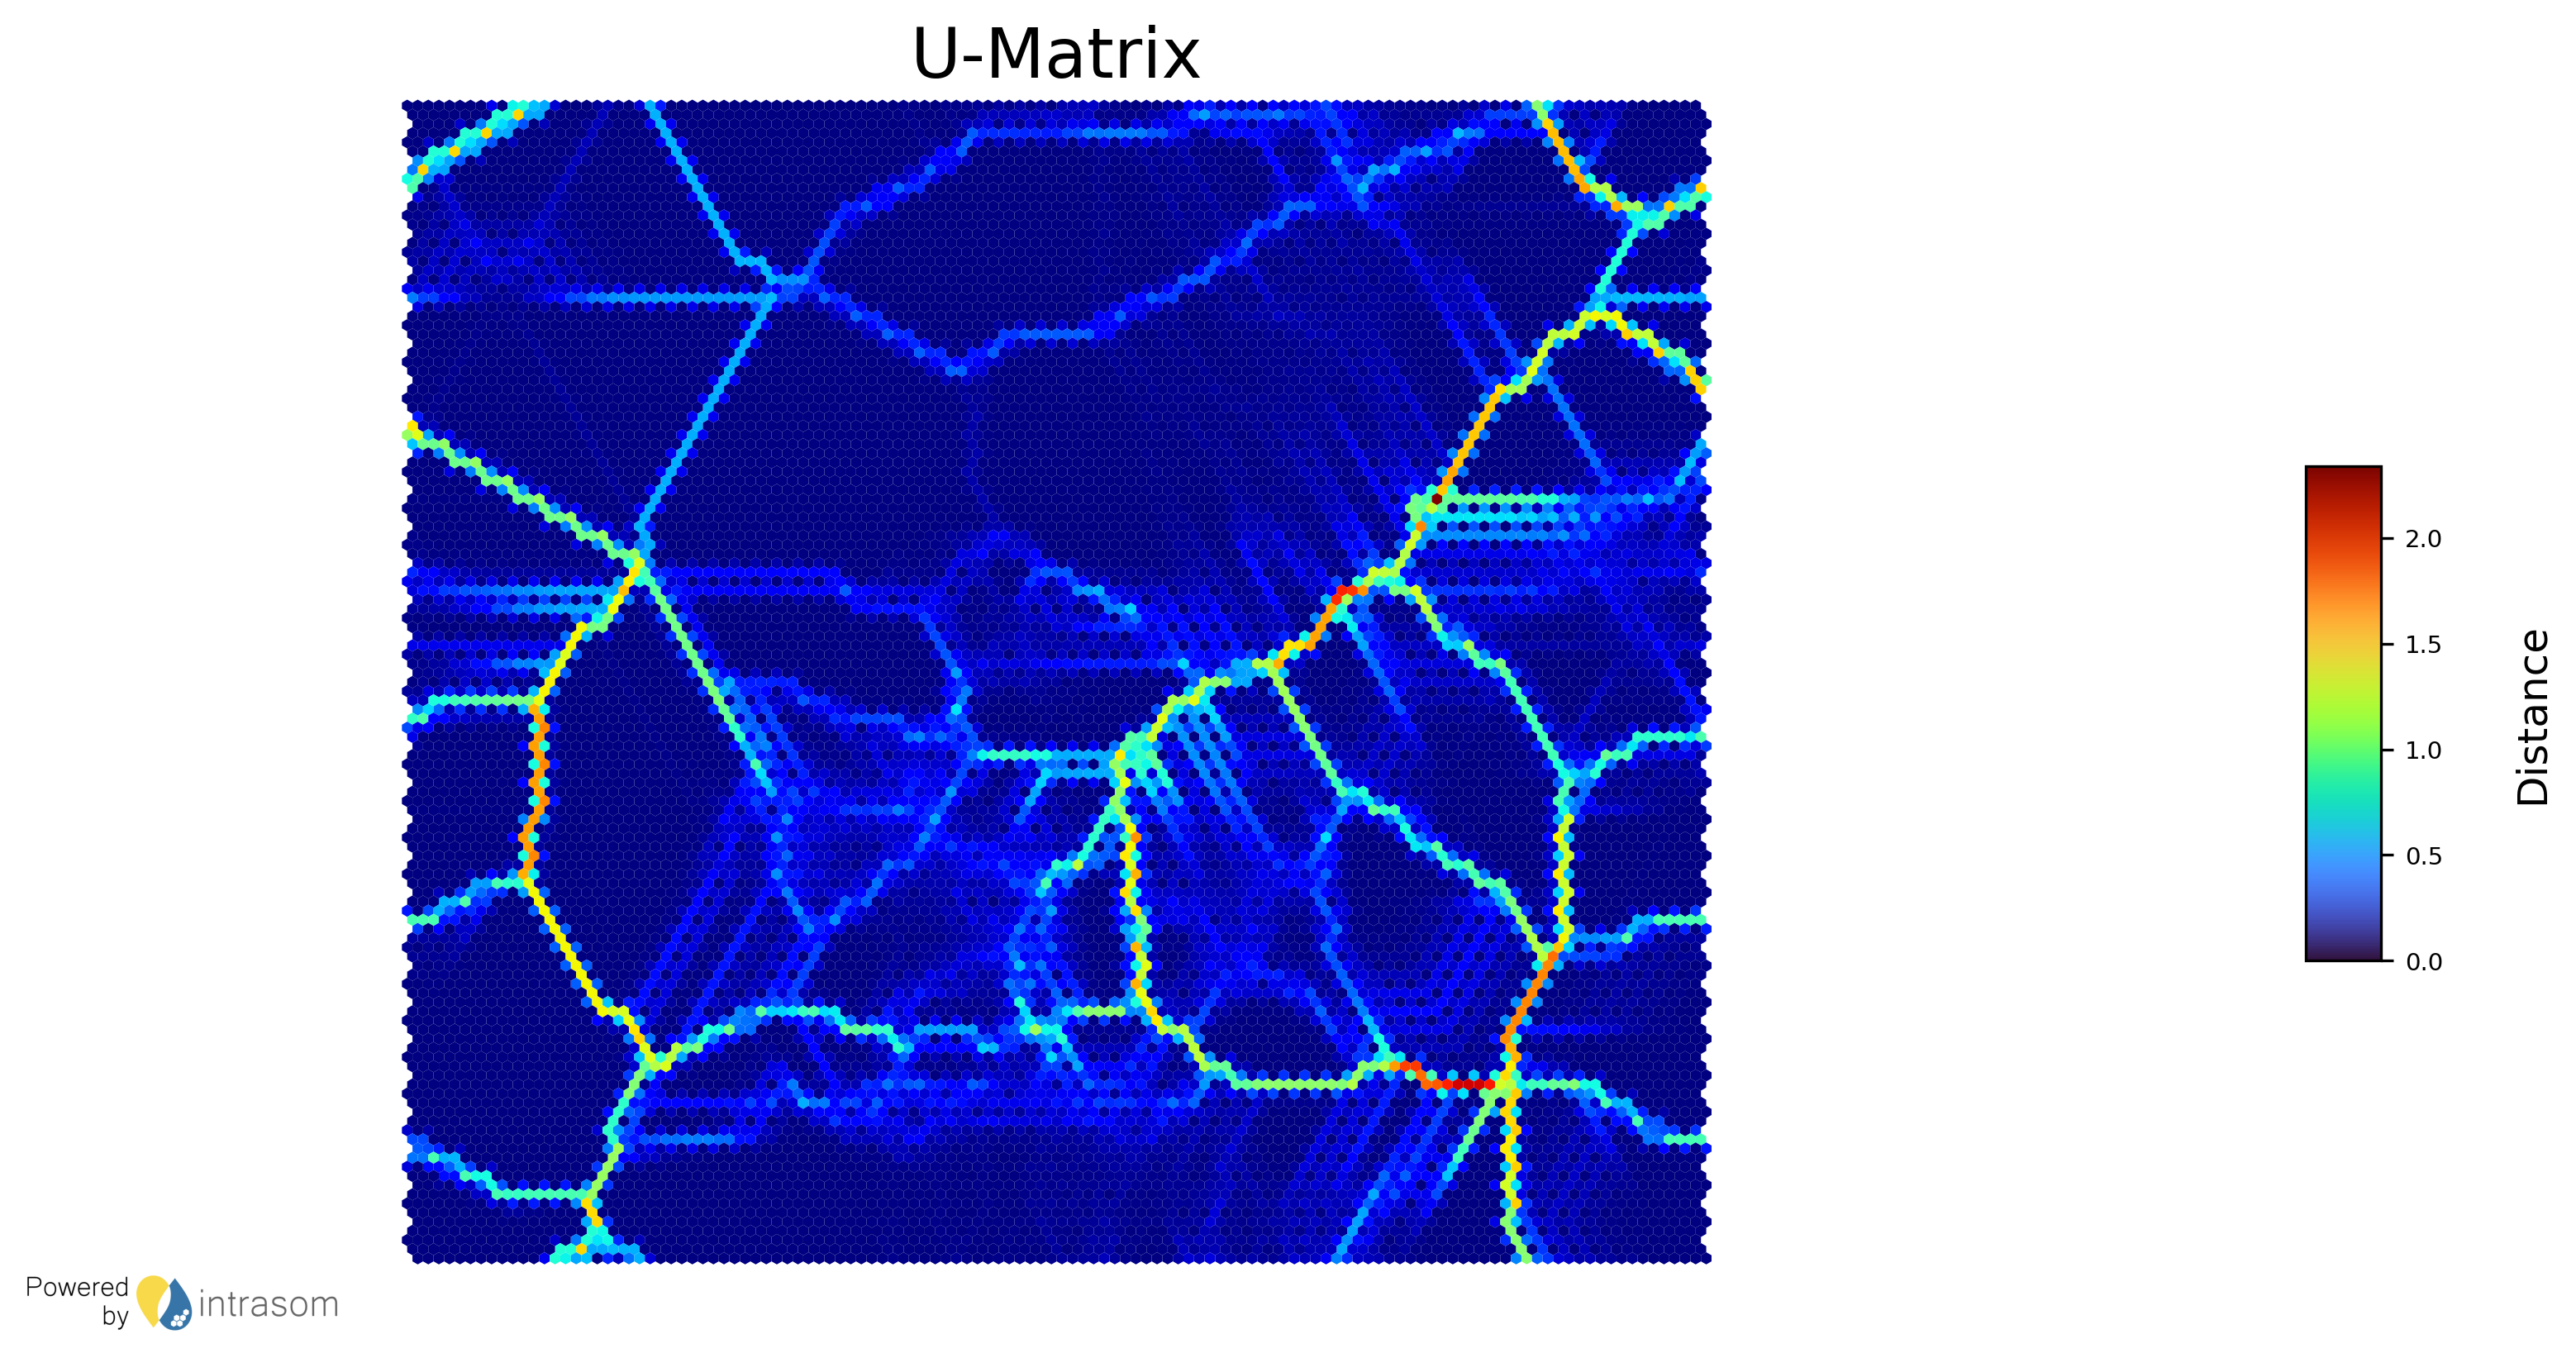

Saving.


In [21]:
plot.plot_umatrix(figsize = (13,2.5),
                  hits = False,
                  title = "U-Matrix",
                  title_size = 20,
                  title_pad = 20,
                  legend_title = "Distance",
                  legend_title_size = 12,
                  legend_ticks_size = 7,
                  label_title_xy = (0,0.5),
                  save = True,
                  file_name = "umatrix",
                  file_path = '',
                  watermark_neurons=False)

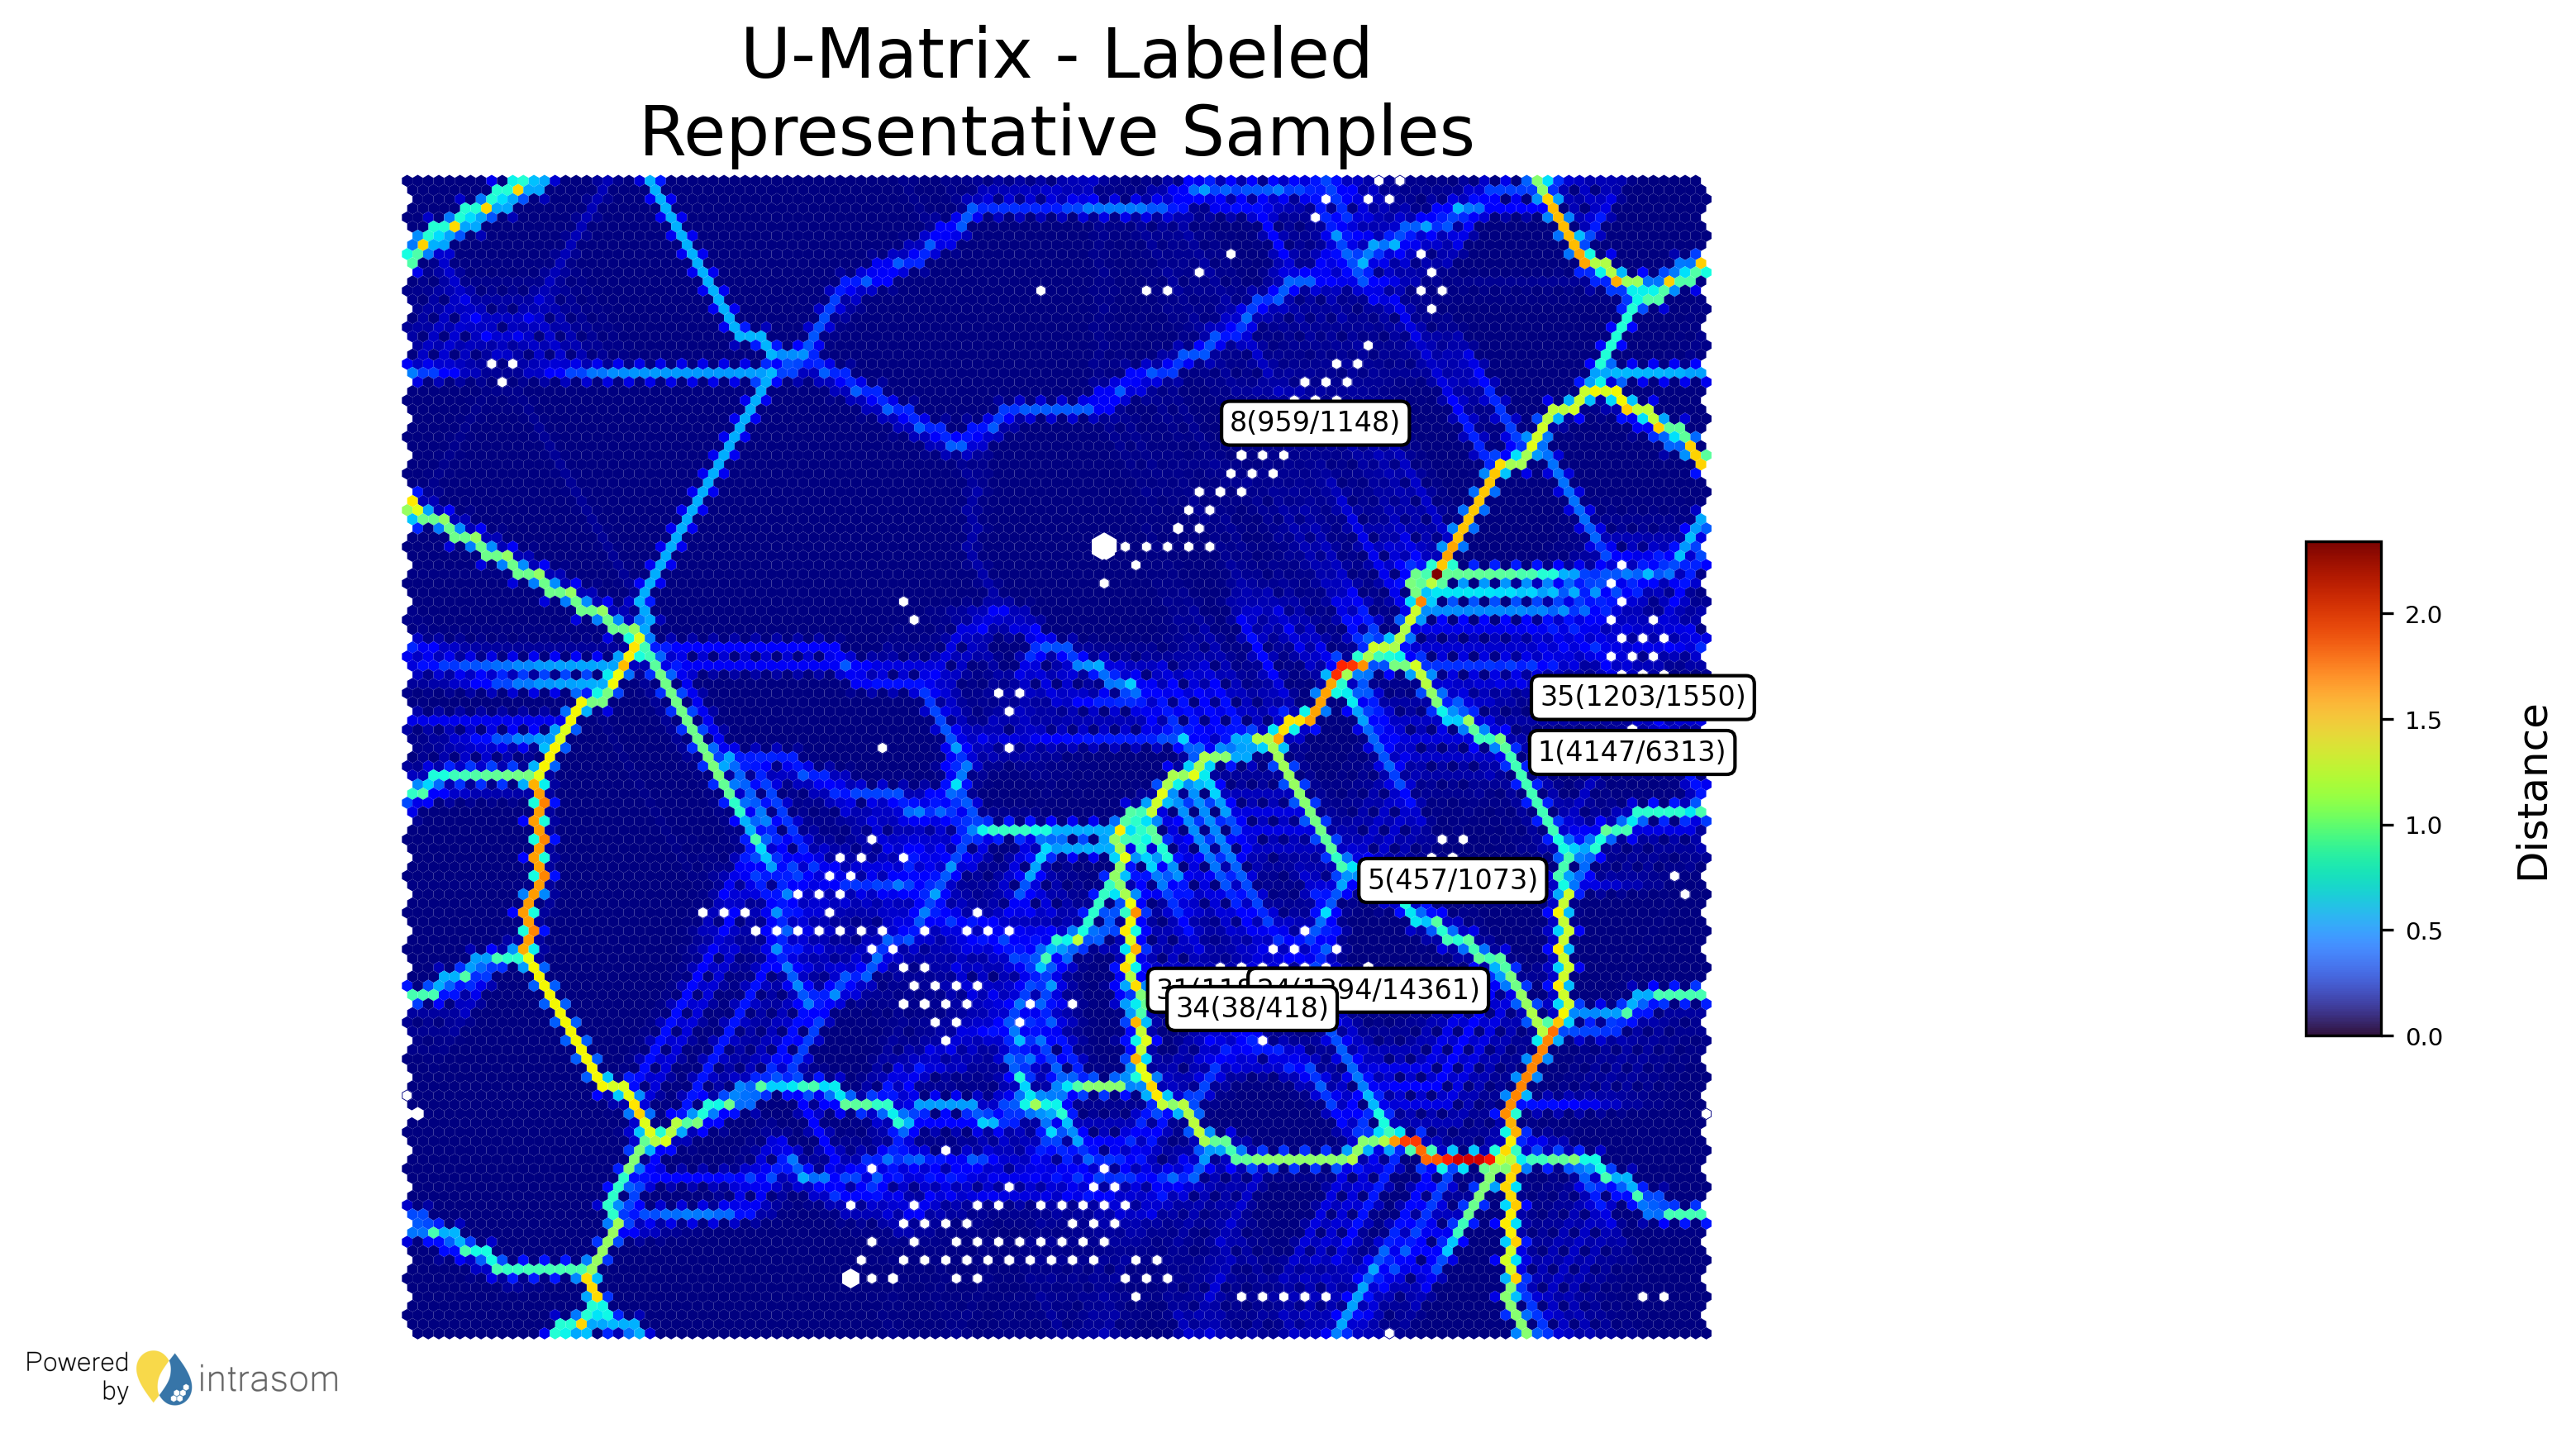

In [45]:
plot.plot_umatrix(figsize = (13,2.5),
                  hits = True,
                  title = "U-Matrix - Labeled Representative Samples",
                  title_size = 20,
                  title_pad = 20,
                  legend_title = "Distance",
                  legend_title_size = 12,
                  legend_ticks_size = 7,
                  label_title_xy = (0,0.5),
                  save = False,
                  file_name = "umatrix_sample_labels",
                  file_path = False,
                  watermark_neurons=False,
                  samples_label = True,
                  samples_label_index = range(35),
                  samples_label_fontsize = 8,
                  save_labels_rep = True)

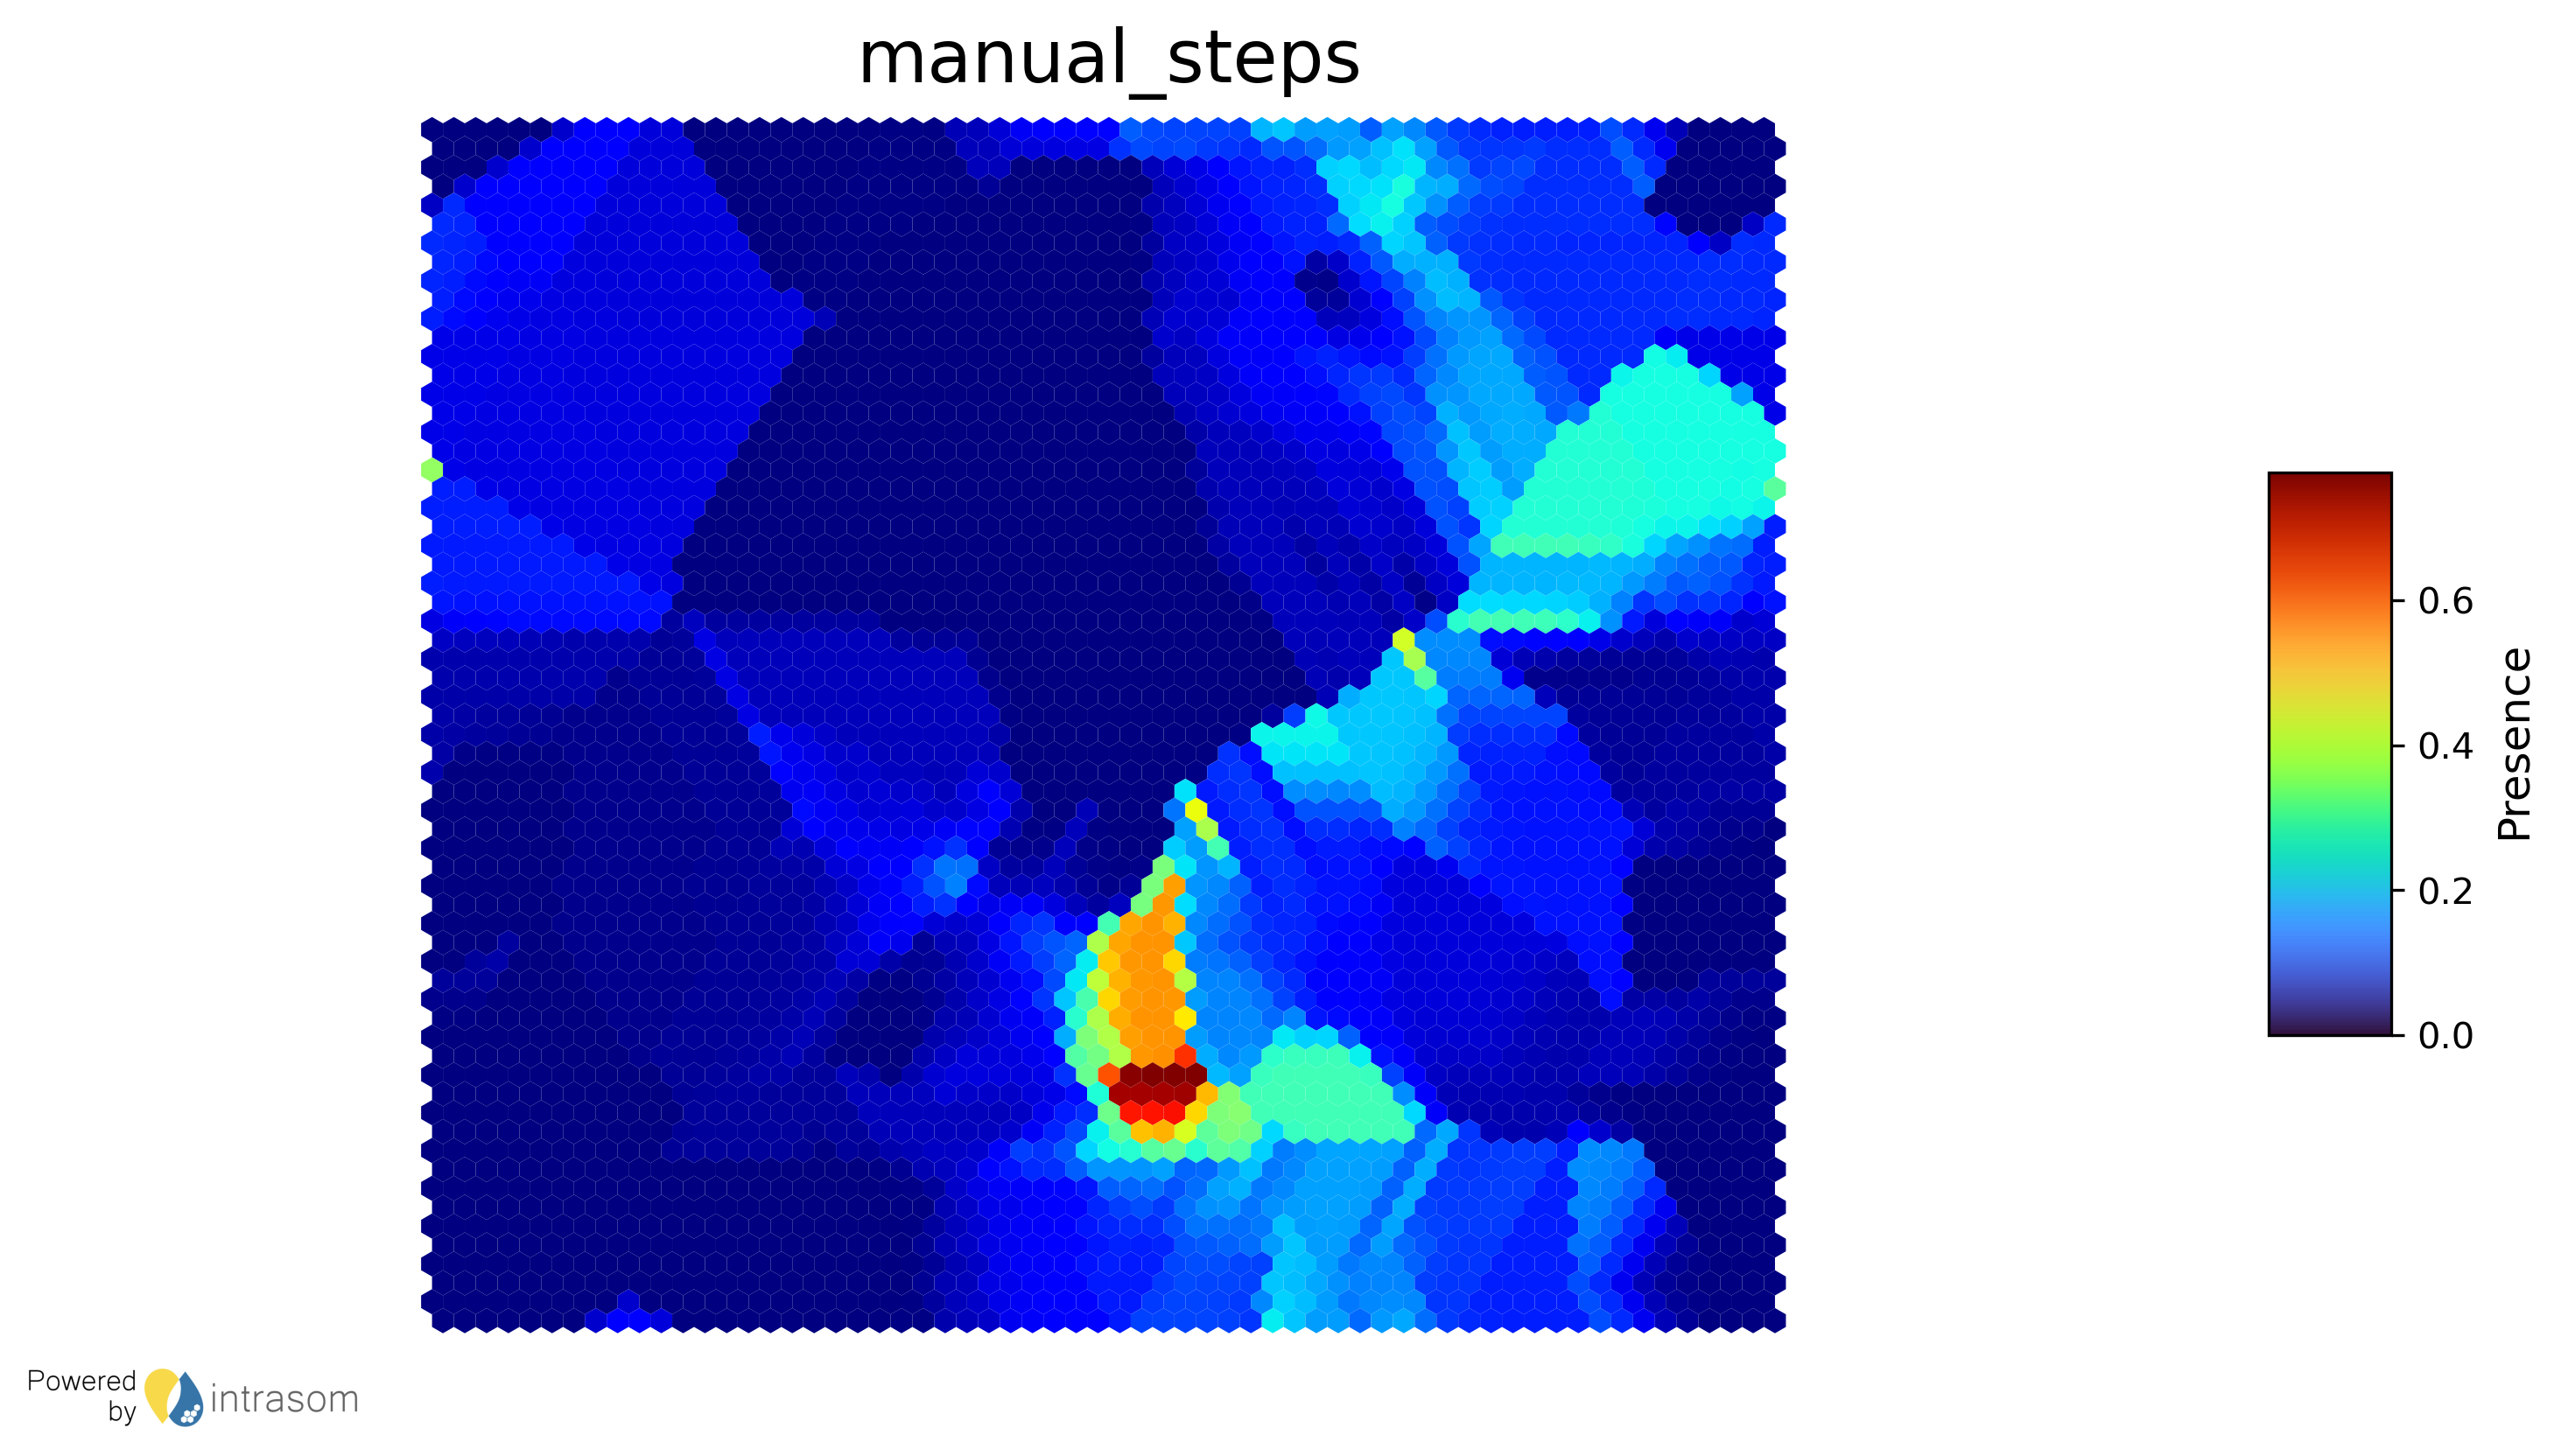

In [53]:
plot.component_plot(figsize = (12,2.5),
                    component_name =2,
                    title_size = 20,
                    legend_title = "Presence",
                    legend_pad = 5,
                    legend_title_size = 12,
                    legend_ticks_size = 10,
                    label_title_xy = (0,0.7))

#### 9. Clustering K-Means

In [30]:
clustering = ClusterFactory(som_vis)
clusters_10 = clustering.kmeans(k=10)
clusters_20 = clustering.kmeans(k=20)
clusters_30 = clustering.kmeans(k=30)
cases_10 = clustering.results_cluster(clusters_10)
cases_10['case_id'] = features['case_id'].values
cases_20 = clustering.results_cluster(clusters_20)
cases_20['case_id'] = features['case_id'].values
cases_30 = clustering.results_cluster(clusters_30)
cases_30['case_id'] = features['case_id'].values
cases_10.to_csv("M_setting/clusters_10.csv", index=False)
cases_20.to_csv("M_setting/clusters_20.csv", index=False)
cases_30.to_csv("M_setting/clusters_30.csv", index=False)

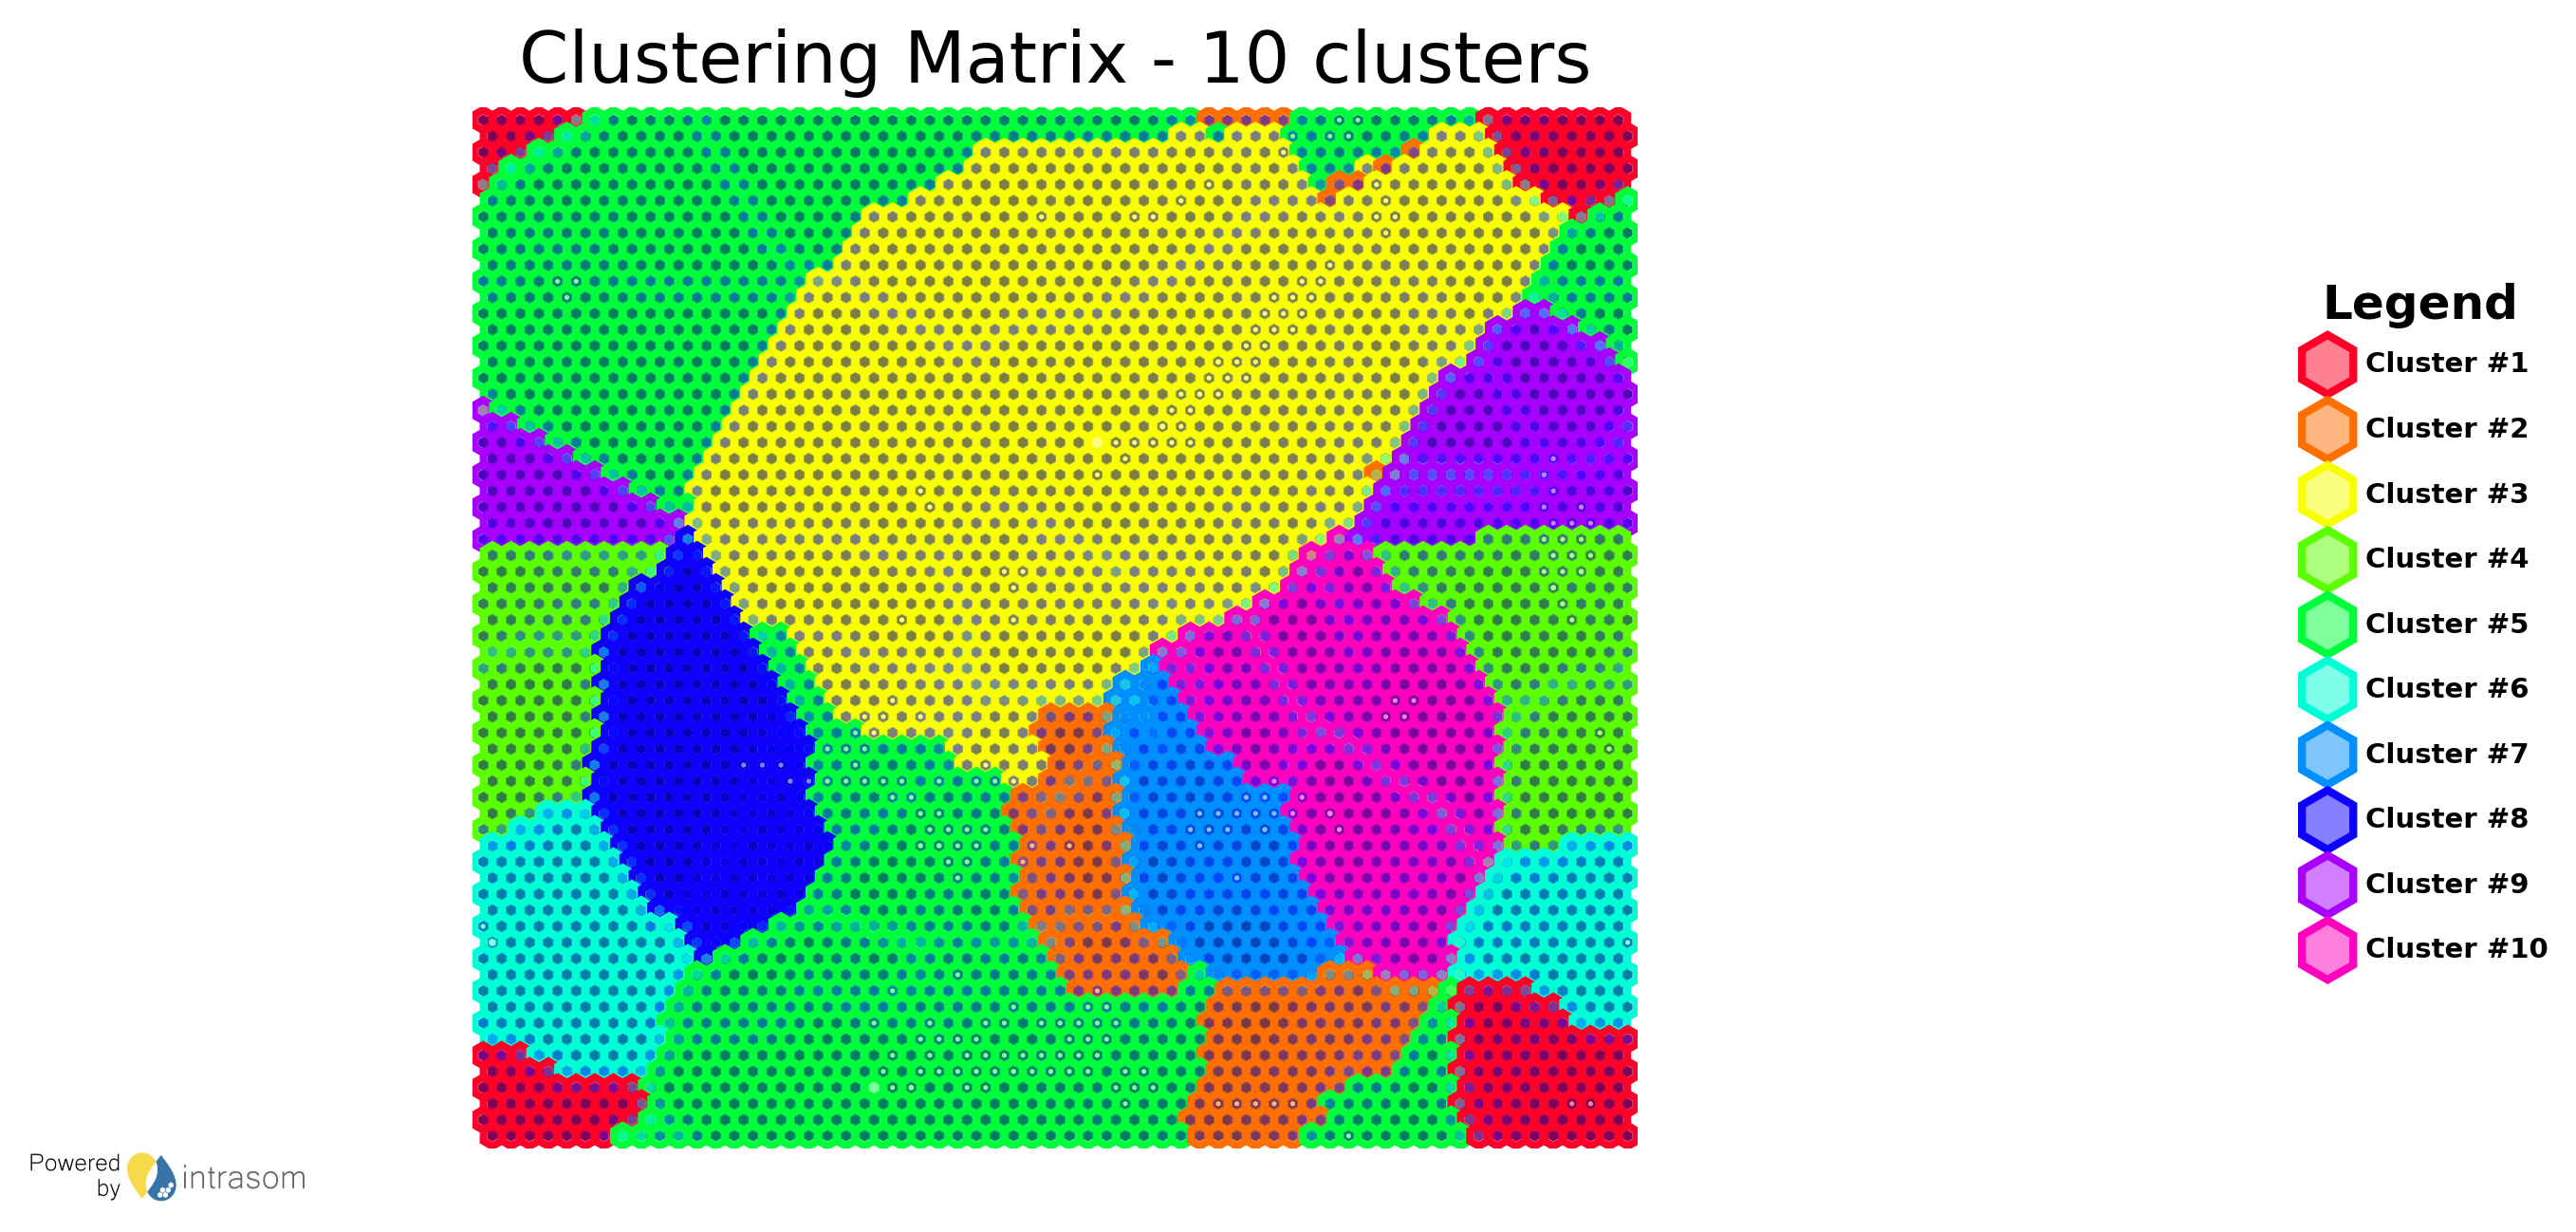

In [31]:
clustering.plot_kmeans(figsize = (12,5),
                       clusters = clusters_10,
                       title_size = 18,
                       title_pad = 20,
                       umatrix=True,
                       colormap = "gist_rainbow",
                       alfa_clust=0.5,
                       hits=True,
                       legend_text_size =7,
                       cluster_outline=False,
                       save=True,
                       file_name="cluster_gist_100")

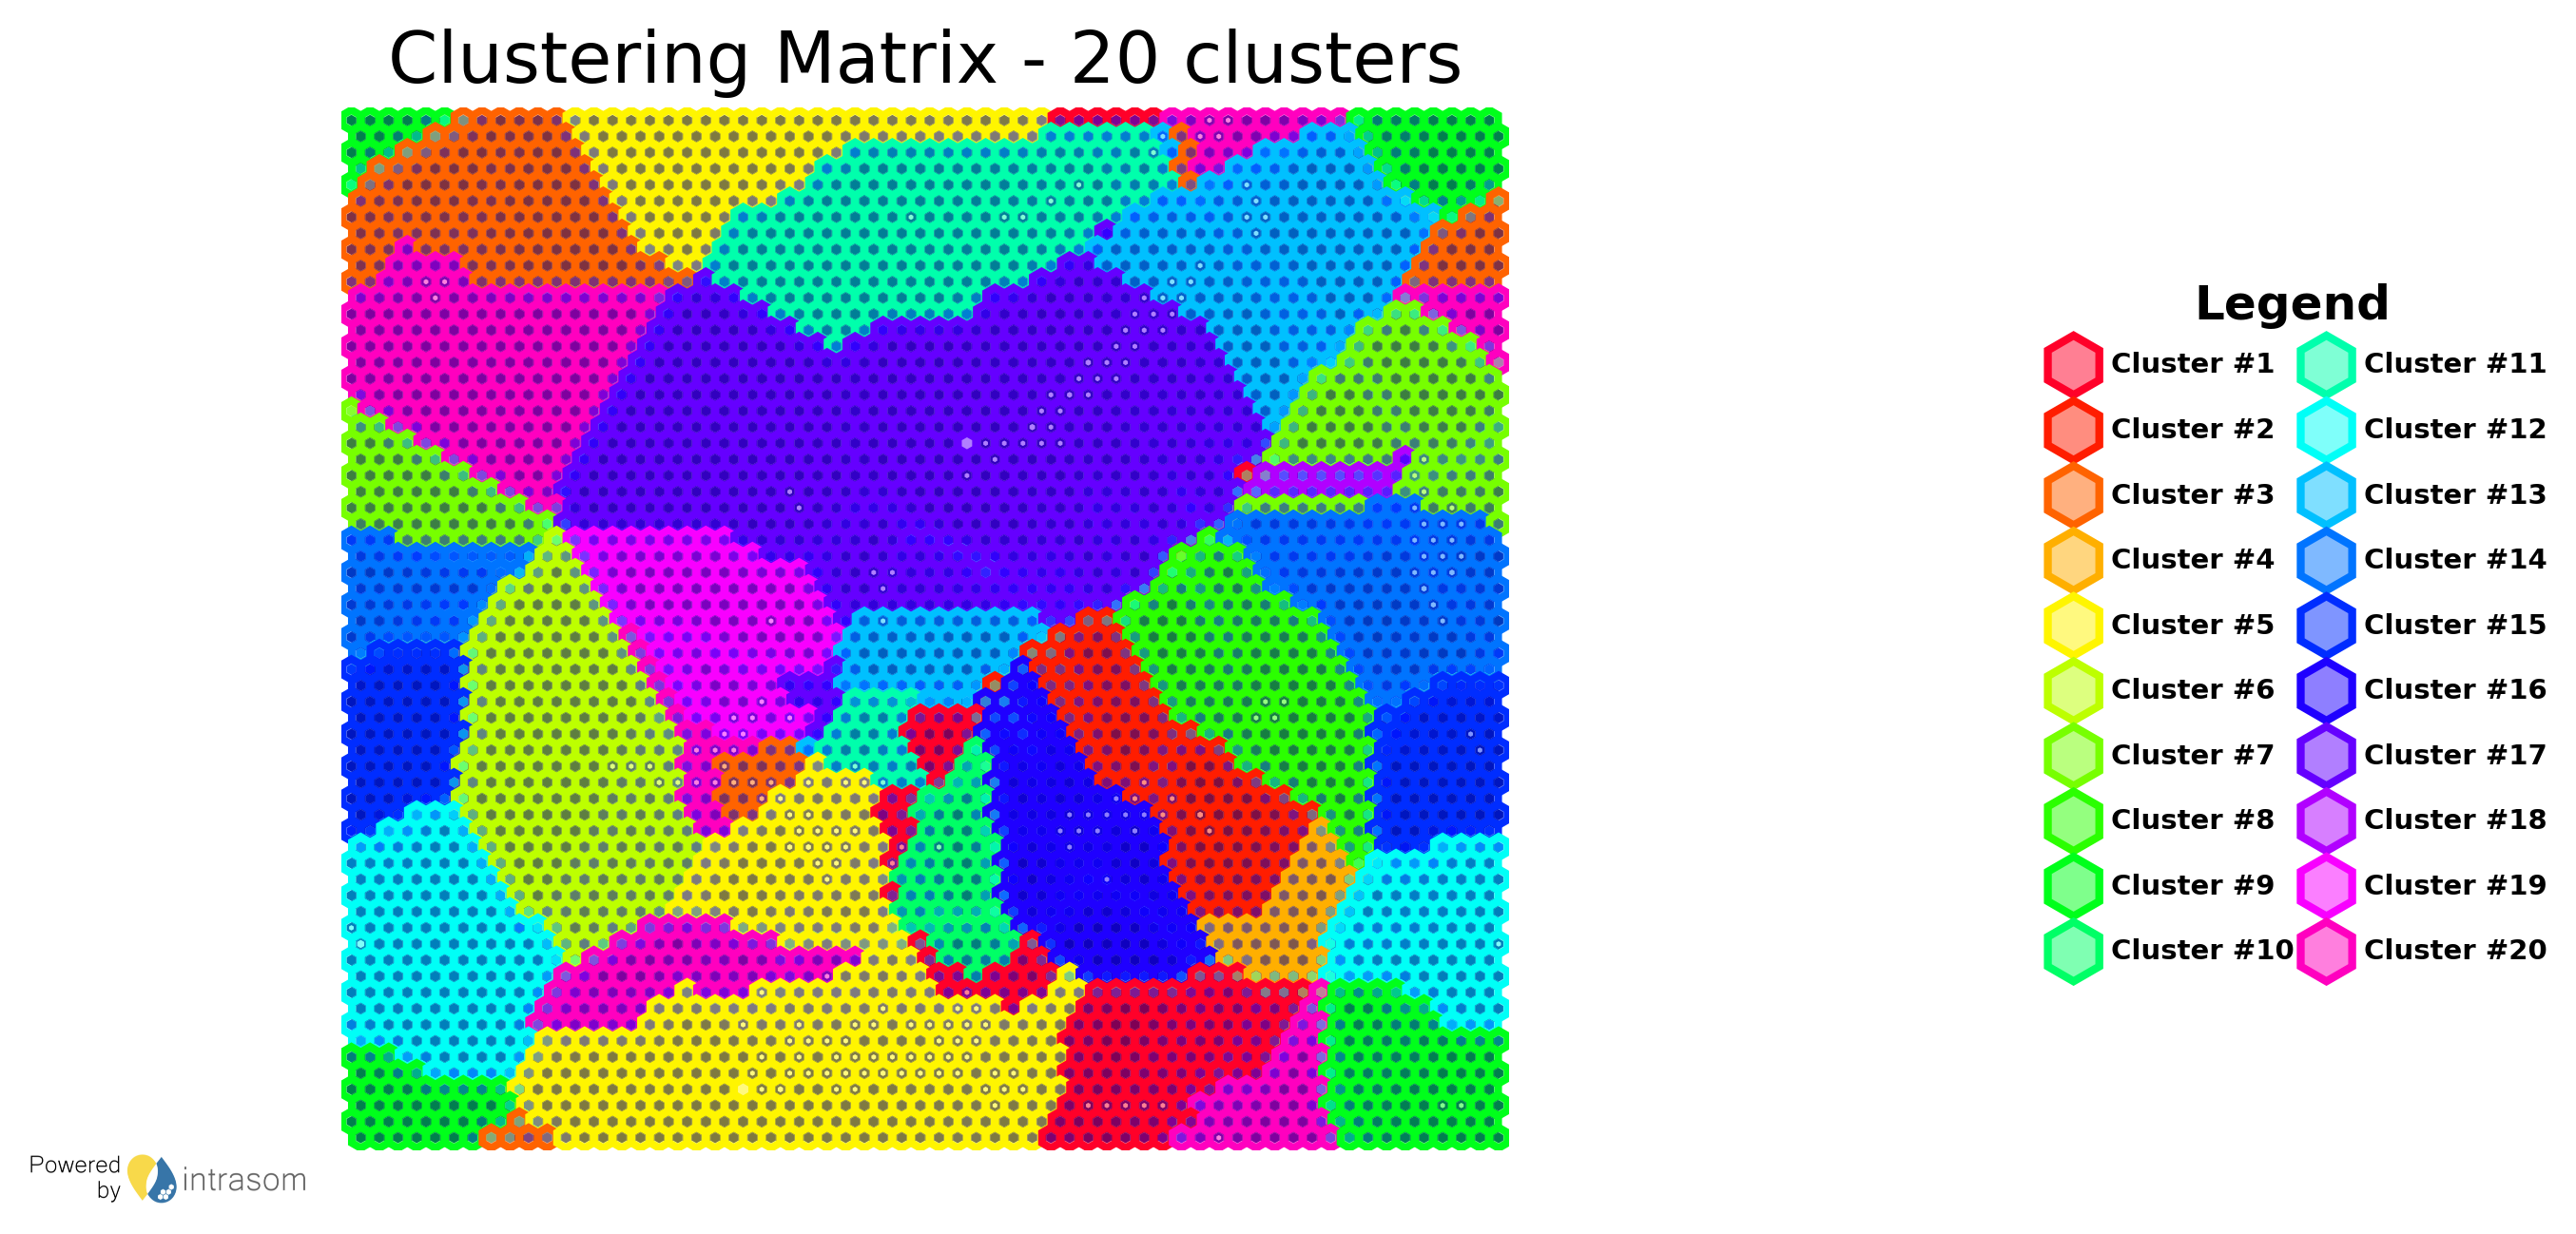

In [32]:
clustering.plot_kmeans(figsize = (12,5),
                       clusters = clusters_20,
                       title_size = 18,
                       title_pad = 20,
                       umatrix=True,
                       colormap = "gist_rainbow",
                       alfa_clust=0.5,
                       hits=True,
                       legend_text_size =7,
                       cluster_outline=False,
                       save=True,
                       file_name="cluster_gist_20")

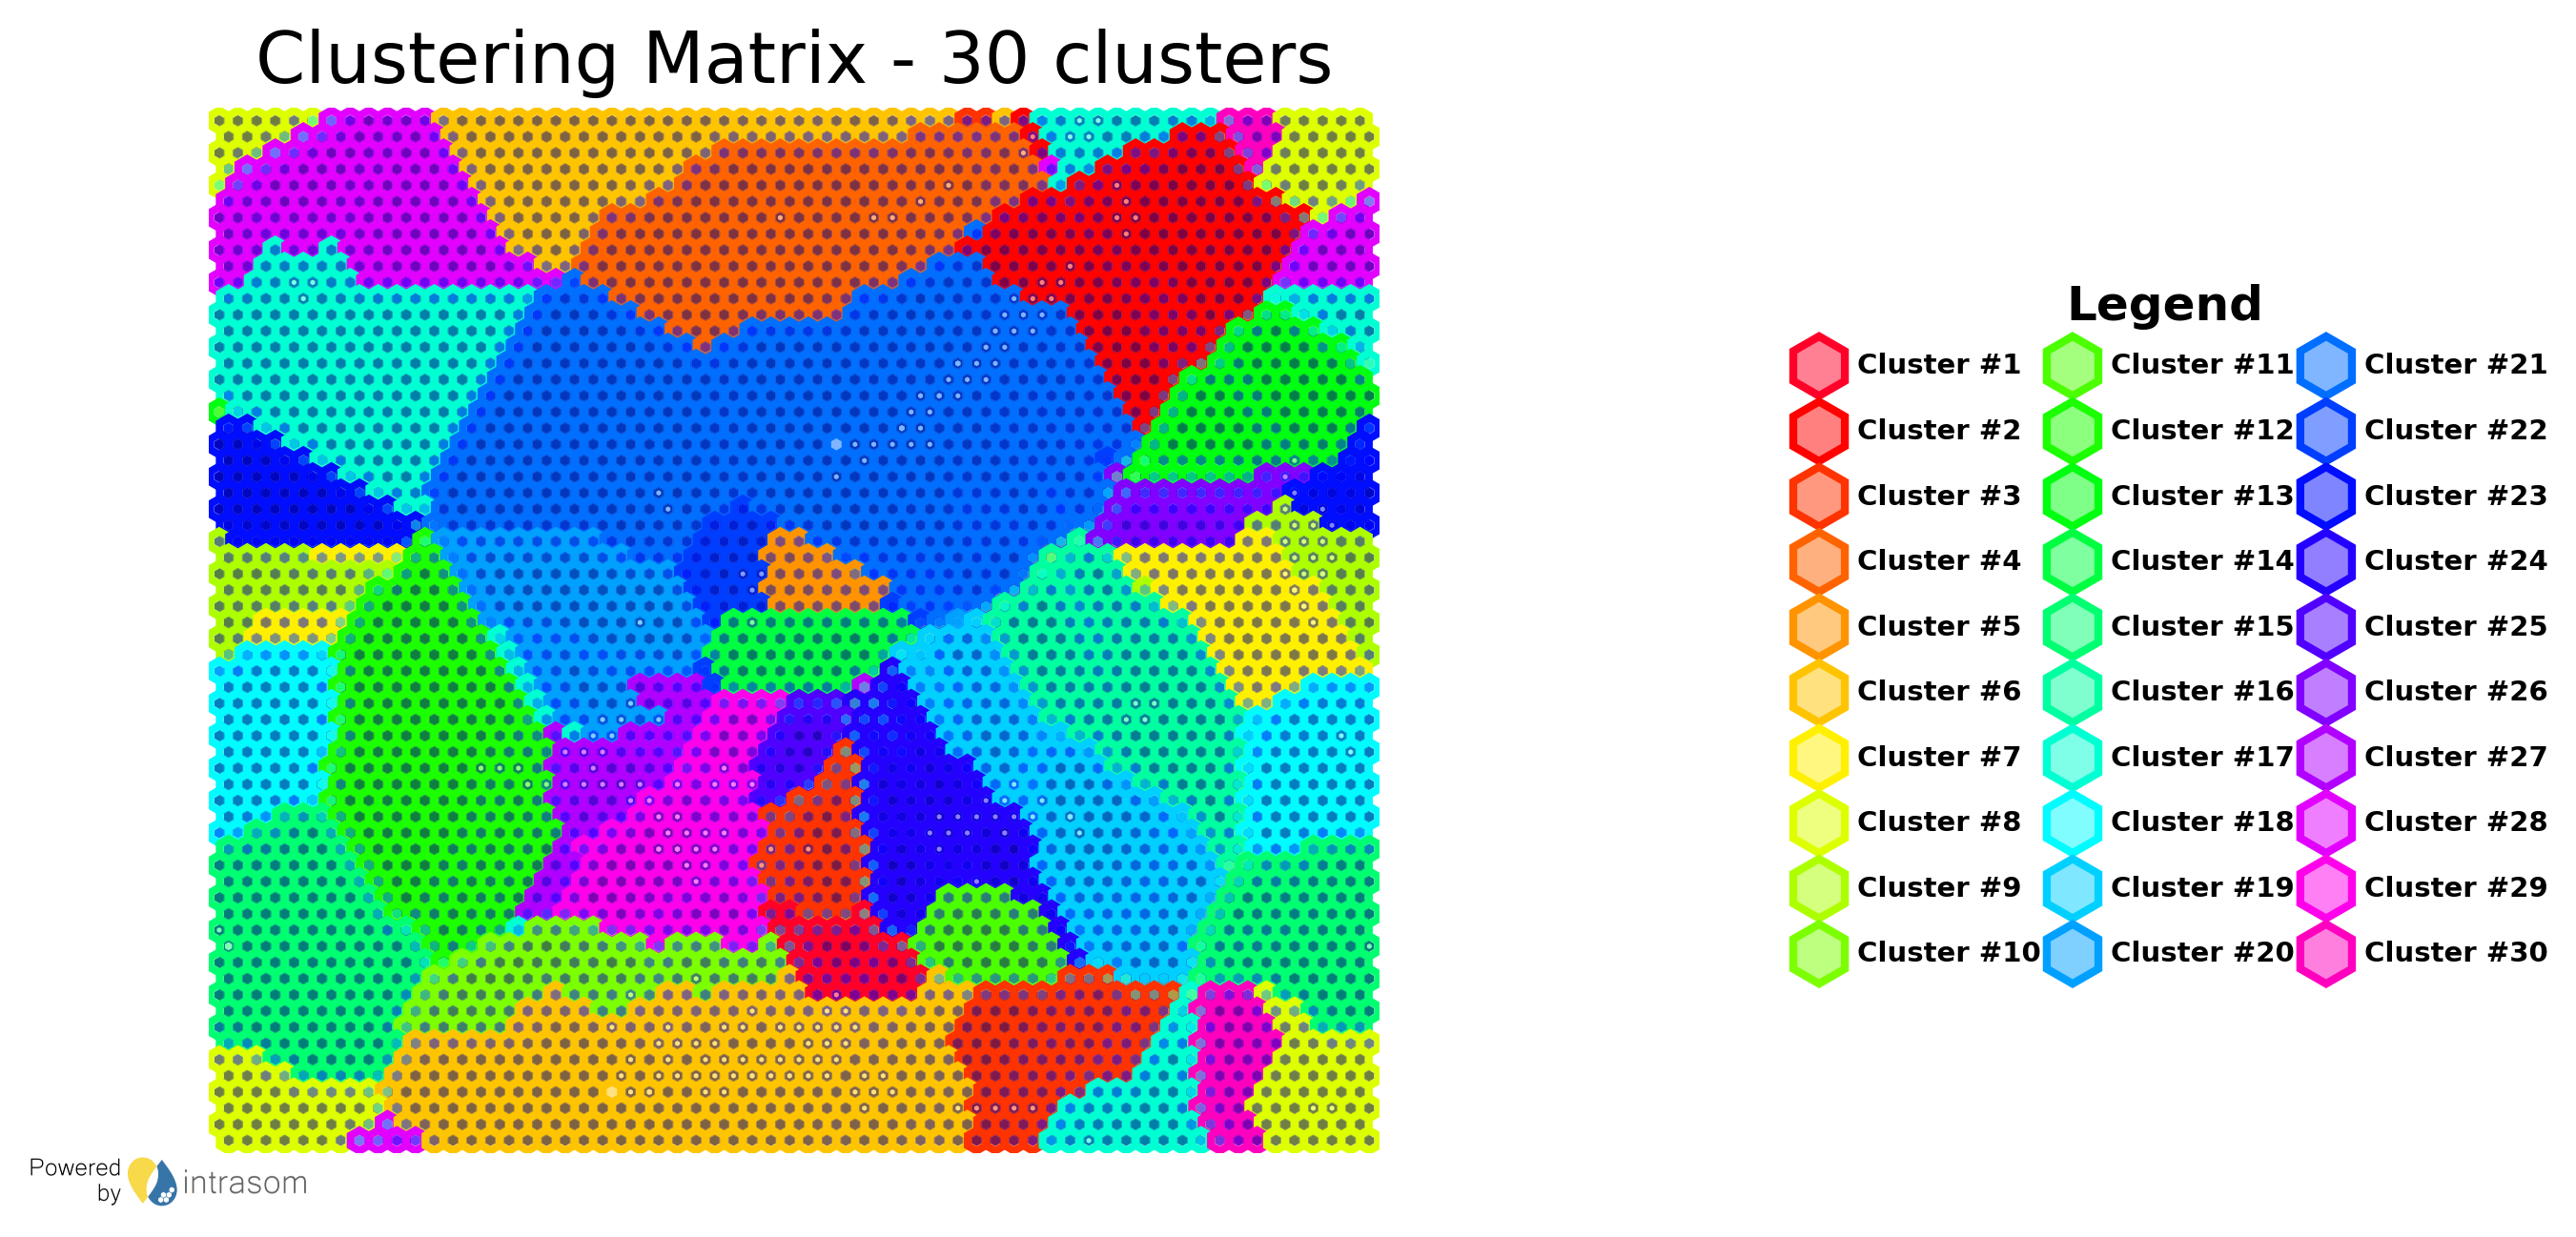

In [33]:
clustering.plot_kmeans(figsize = (12,5),
                       clusters = clusters_30,
                       title_size = 18,
                       title_pad = 20,
                       umatrix=True,
                       colormap = "gist_rainbow",
                       alfa_clust=0.5,
                       hits=True,
                       legend_text_size =7,
                       cluster_outline=False,
                       save=True,
                       file_name="cluster_gist_30")

### 10. Visualize clustered process flows

In [35]:
feature_matrix = pandas.read_csv("M_setting/clusters_10.csv",  delimiter=",", encoding='utf-8', quoting=csv.QUOTE_NONE, quotechar='"')

In [36]:
count_clusters = feature_matrix.groupby('10_clusters').size().reset_index(name='count_clusters')

In [37]:
count_clusters

10_clusters  count_clusters
0            1             156
1            2             254
2            3          315446
3            4           29390
4            5          197365
5            6           46254
6            7            6206
7            8            8267
8            9             525
9           10           15534

In [42]:
selected_df = feature_matrix[feature_matrix['10_clusters'] == 2][['case_id']]

In [43]:
event_log_filtered = event_log[event_log['case_id'].isin(selected_df['case_id'].unique())]

event_log_ = event_log_filtered.sort_values(by=['case_id', 'timestamp', 'SORTKEY'])

event_log_tr = pm4py.format_dataframe(event_log_filtered, case_id='case_id', activity_key='activity', timestamp_key='timestamp')
dfg, start_activities, end_activities = pm4py.discover_dfg(event_log_tr, activity_key='activity', case_id_key='case_id', timestamp_key='timestamp')
pm4py.save_vis_dfg(dfg, start_activities, end_activities, 'm_cluster_2.png')

''